# Extracting Rules with XAI from RAPP predictions

## Dropout when no exams in last three semesters

In [1]:
import pandas as pd
import numpy as np

from rapp import data

In [2]:
data.connect("data/rapp.db")

In [3]:
sql = "sql/cs_first_term_dropout.sql"
df = data.query_sql_file(sql, data.db_conn)

df

,Geburtsjahr,Geschlecht,Deutsch,AlterEinschreibung,KlausurenGeschrieben,KlausurenBestanden,Ects,DurchschnittsNote,StdevNoteQuadriert,Dropout
0,1976,männlich,1,21,5,4,44.0,1.712500,0.172969,0
1,1984,männlich,1,20,5,5,30.0,3.675000,0.049500,1
2,1981,männlich,1,23,1,1,10.0,2.700000,0.000000,1
3,1985,männlich,1,20,14,14,140.0,1.962500,0.404196,1
4,1983,männlich,1,22,7,7,70.0,2.766667,0.703810,0
...,...,...,...,...,...,...,...,...,...,...
1003,1988,weiblich,1,31,6,6,43.0,1.333333,0.082222,1
1004,1994,männlich,1,25,1,1,5.0,3.300000,0.000000,1
1005,1994,männlich,1,25,1,0,0.0,5.000000,0.000000,1
1006,1986,weiblich,1,33,1,0,0.0,5.000000,0.000000,1


In [4]:
df_classification = df.copy(deep=True)
df_classification["StdevNote"] = np.sqrt(df["StdevNoteQuadriert"])
df_classification = df_classification.drop(["StdevNoteQuadriert"], axis=1)

In [5]:
df_classification.head()

,Geburtsjahr,Geschlecht,Deutsch,AlterEinschreibung,KlausurenGeschrieben,KlausurenBestanden,Ects,DurchschnittsNote,Dropout,StdevNote
0,1976,männlich,1,21,5,4,44.0,1.712500,0,0.415895
1,1984,männlich,1,20,5,5,30.0,3.675000,1,0.222486
2,1981,männlich,1,23,1,1,10.0,2.700000,1,0.000000
3,1985,männlich,1,20,14,14,140.0,1.962500,1,0.635764
4,1983,männlich,1,22,7,7,70.0,2.766667,0,0.838934


We need to one-hot encode the gender.

In [6]:
df_classification["Männlich"] = 1*(df_classification["Geschlecht"] == "männlich")
df_classification["Weiblich"] = 1*(df_classification["Geschlecht"] == "weiblich")
df_classification["Divers"] = 1*(df_classification["Geschlecht"] == "divers")

df_classification = df_classification.drop(["Geschlecht", "Geburtsjahr"], axis=1)

In [7]:
df_classification.head()

,Deutsch,AlterEinschreibung,KlausurenGeschrieben,KlausurenBestanden,Ects,DurchschnittsNote,Dropout,StdevNote,Männlich,Weiblich,Divers
0,1,21,5,4,44.0,1.712500,0,0.415895,1,0,0
1,1,20,5,5,30.0,3.675000,1,0.222486,1,0,0
2,1,23,1,1,10.0,2.700000,1,0.000000,1,0,0
3,1,20,14,14,140.0,1.962500,1,0.635764,1,0,0
4,1,22,7,7,70.0,2.766667,0,0.838934,1,0,0


### Prepare train and test set

In [8]:
X = df_classification.drop(["Dropout"], axis=1)
y = df_classification["Dropout"]

feature_names = X.columns

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

### Train classifier

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix

In [11]:
clf = DecisionTreeClassifier(class_weight="balanced", min_impurity_decrease=0.001)

In [12]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

In [13]:
y_pred = clf.predict(X_train)
bacc = balanced_accuracy_score(y_train, y_pred)
conf = confusion_matrix(y_train, y_pred)
print("# Trainset")
print(f"Balanced accuracy: {bacc}")
print(f"Confusion Matrix (tn, fp, fn, tp):")
print(conf)

y_pred = clf.predict(X_test)
bacc = balanced_accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
print("# Testset")
print(f"Balanced accuracy: {bacc}")
print(f"Confusion Matrix (tn, fp, fn, tp):")
print(conf)

# Trainset
Balanced accuracy: 0.8595588583329389
Confusion Matrix (tn, fp, fn, tp):
[[169  16]
 [111 460]]
# Testset
Balanced accuracy: 0.6735377168212989
Confusion Matrix (tn, fp, fn, tp):
[[ 41  26]
 [ 49 136]]


### Display rules learned

In [14]:
%matplotlib inline
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [60, 20]

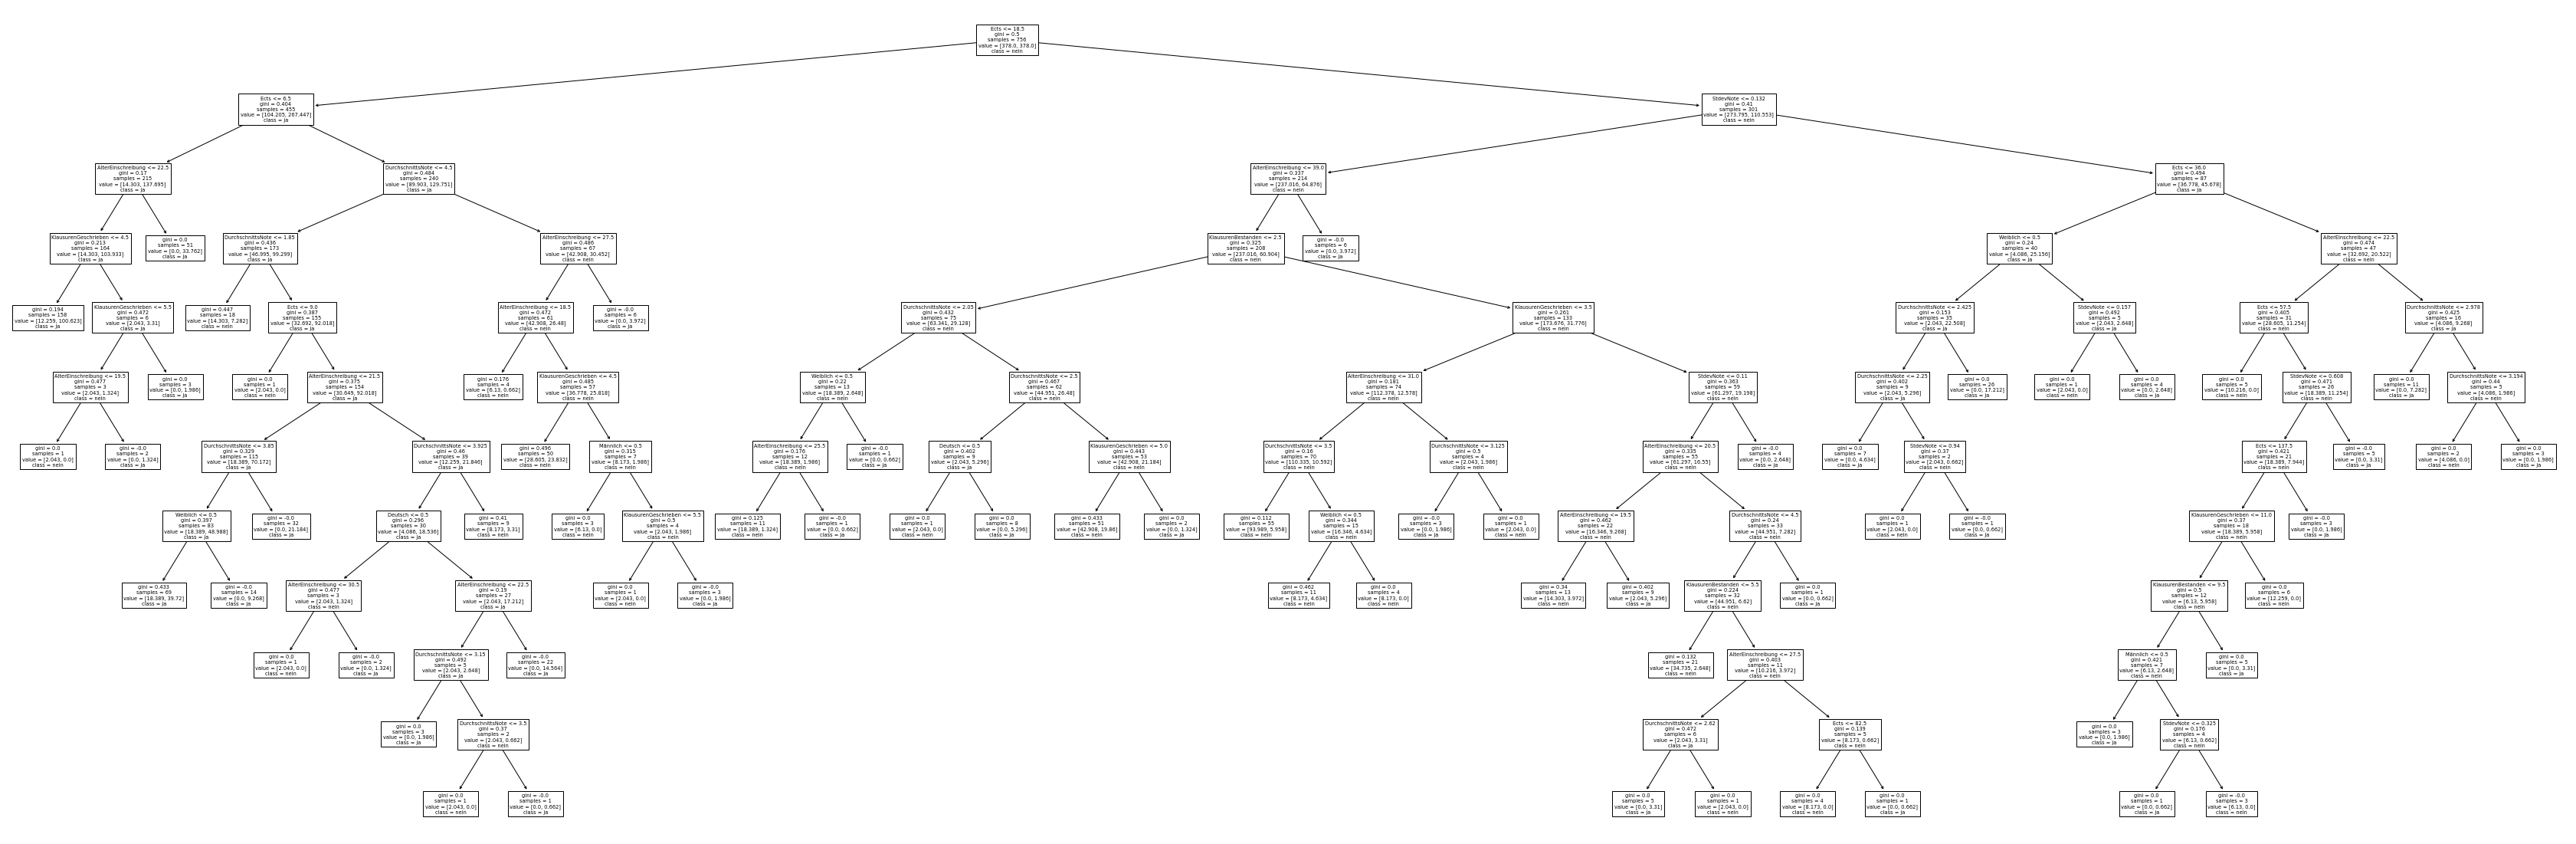

In [15]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

(Right click image -> open in new tab to get a zoomable version.)

### Post pruning of the decision tree

This complexity post pruning approach follows the example from https://ranvir.xyz/blog/practical-approach-to-tree-pruning-using-sklearn/ closely.

In [16]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00132275, 0.00132275, 0.0013418 , 0.00142805,
        0.00146051, 0.00158061, 0.00160299, 0.00162009, 0.00172835,
        0.00178071, 0.0018164 , 0.00183628, 0.00201307, 0.0021124 ,
        0.00211769, 0.00217225, 0.00217944, 0.00288577, 0.00304733,
        0.00317604, 0.00320614, 0.0033306 , 0.00334151, 0.00334523,
        0.00339236, 0.00353565, 0.00380059, 0.00396703, 0.00433705,
        0.00448446, 0.00656327, 0.00780738, 0.00898583, 0.01124568,
        0.01969835, 0.02361052, 0.09327566]),
 'impurities': array([0.19759759, 0.19892035, 0.2002431 , 0.20561031, 0.20846642,
        0.21138743, 0.21296804, 0.21457103, 0.21619112, 0.21791947,
        0.21970018, 0.22333298, 0.23067809, 0.23470423, 0.24315385,
        0.24527154, 0.24961604, 0.25397492, 0.25974646, 0.26888846,
        0.2720645 , 0.27847679, 0.28513798, 0.29182099, 0.29851145,
        0.30868854, 0.31222419, 0.31602478, 0.31999181, 0.32432886,
        0.32881331, 0.33537658, 0.34318396

Text(0, 0.5, 'total impurity of leaves')

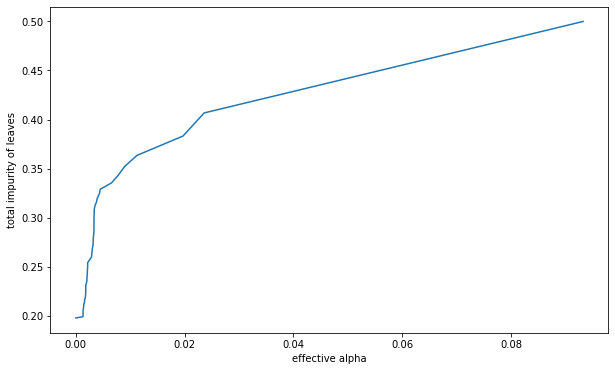

In [17]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")

In [18]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)
    clfs.append(clf)

Text(0, 0.5, 'total depth')

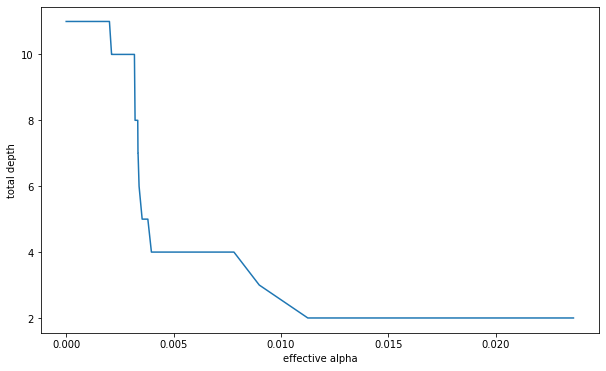

In [19]:
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


Text(0, 0.5, 'Balanced Accuracy scores')

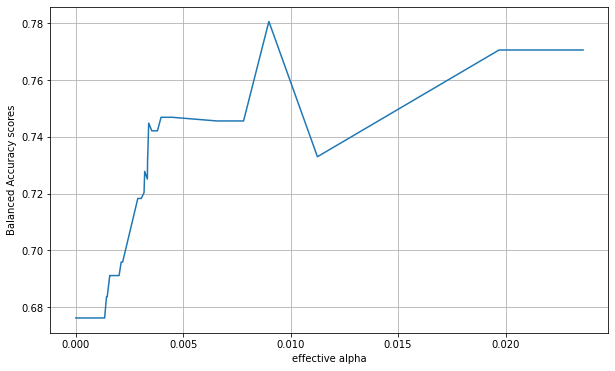

In [20]:
acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")

In [21]:
selected_ccp = 0.009

In [22]:
clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
bacc = balanced_accuracy_score(y_train, y_pred)
conf = confusion_matrix(y_train, y_pred)
print("# Trainset")
print(f"Balanced accuracy: {bacc}")
print(f"Confusion Matrix (tn, fp, fn, tp):")
print(conf)

y_pred = clf.predict(X_test)
bacc = balanced_accuracy_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)
print("# Testset")
print(f"Balanced accuracy: {bacc}")
print(f"Confusion Matrix (tn, fp, fn, tp):")
print(conf)

# Trainset
Balanced accuracy: 0.7437970369669145
Confusion Matrix (tn, fp, fn, tp):
[[132  53]
 [129 442]]
# Testset
Balanced accuracy: 0.7805970149253731
Confusion Matrix (tn, fp, fn, tp):
[[ 51  16]
 [ 37 148]]


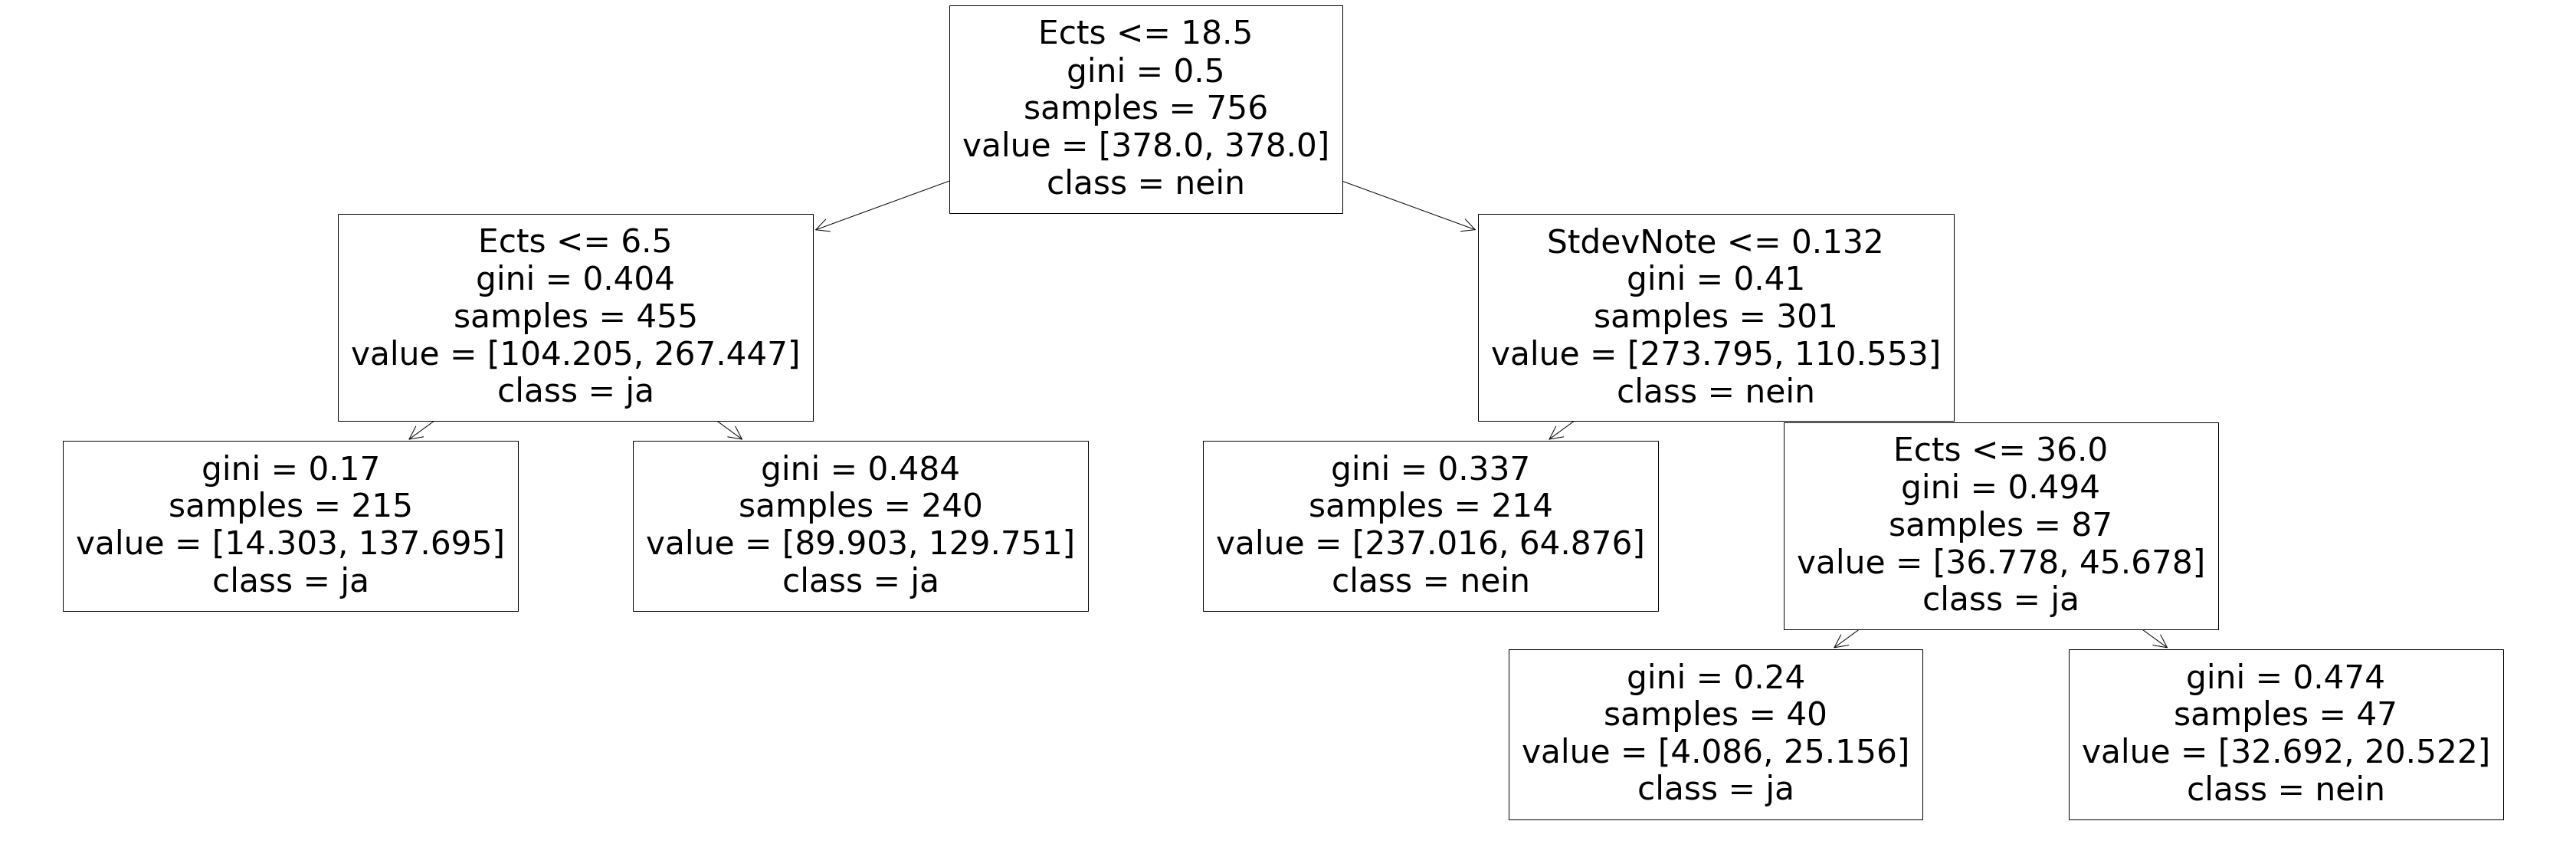

In [23]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()